## The Stokes flow (with cylinder)

### (1) Problem Description
#### (1.1) The governing equation 
The governing PDE is
\begin{equation}
\begin{split}
 -\mu\nabla^2{\bf u} + \nabla p &={\bf 0}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega
\end{split}
\end{equation}
where $p(N/m^2)$ is the pressure, ${\bf u} (m/s)$ is the velocity vector, ${\bf f}$ is the applied body force, $\mu$ is the dynamic viscosity.
A typical set of boundary conditions on the boundary $\partial\Omega = \Gamma_D\cup \Gamma_N$ can be:
\begin{equation}
\begin{split}
 {\bf u} = {\bf u}_0, \quad \text{on}\ \Gamma_D \\
(\nabla\cdot{\bf u}+p)\cdot\vec{n} = g\quad \text{on}\ \Gamma_N
\end{split}
\end{equation}
#### (1.2) The continuum and constitutive formulations
\begin{equation}
\begin{split}
- \nabla\cdot {\bf \sigma}  &= {\bf f}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega 
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) 
\end{equation}
is the Cauchy stress tensor, and $p=-tr({\bf \sigma})/2$.
#### (1.3) The weak form
\begin{equation}
\begin{split}
\int {\bf \sigma} \cdot\nabla^T\psi ~dx =  \int {\bf f}\psi~dx
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) ,
\end{equation}
and $p=-tr({\bf \sigma})/2$.
#### (1.4) The problem
The domain is given in the following figure, and the initial/boundary conditions are given as:
- **In flow:** ${\bf u}=(a, 0)$
- **Out flow:** $p=0$
- **non-slip wall:** ${\bf u}={\bf 0}$
- **Cylinder:** ${\bf u=0}$
  
For the parameters in the equation, we set  $\mu=0.01$. Our goal is to learn the following map:
$$
\mathcal{G}: a(x)\longrightarrow (\textbf{u}, p)
$$

### (2) Prepare Data

The shape of uvp_train: torch.Size([1000, 1708, 3])
The shape of x_train: torch.Size([1000, 1708, 2])
***********************************
The shape of uvp_test: torch.Size([200, 1708, 3])
The shape of x_test: torch.Size([200, 1708, 2])
The shape of gridx: torch.Size([1708, 2])
***********************************
The shape of a_train: torch.Size([1000, 256])
The shape of a_test: torch.Size([200, 256])


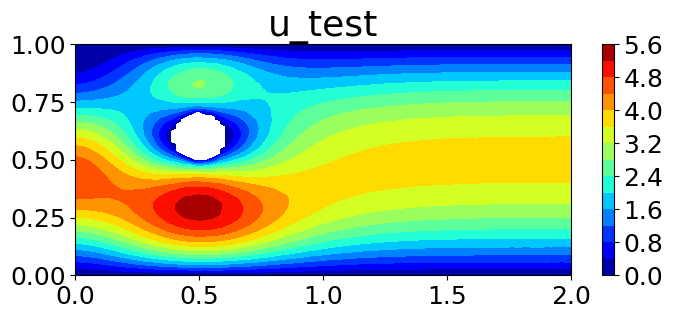

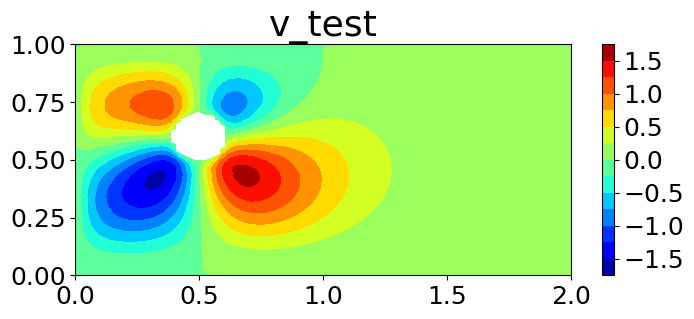

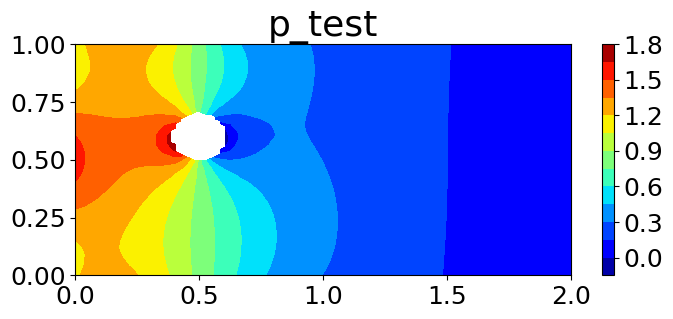

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py
import torch 
import random
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32

####################################
# Load data
####################################
from Utils.utils import *
def get_data(data, dtype):
    u = np2tensor(np.array(data["u"]), dtype)
    v = np2tensor(np.array(data["v"]), dtype)
    p = np2tensor(np.array(data["p"]), dtype)
    gridx = np2tensor(np.array(data["gridx"]), dtype)
    #
    beta1 = np2tensor(np.array(data["beta1"]), dtype)
    beta2 = np2tensor(np.array(data["beta2"]), dtype)
    #
    ndata = u.shape[0]
    u = u.reshape(ndata, -1, 1)
    v = v.reshape(ndata, -1, 1)
    p = p.reshape(ndata, -1, 1)
    uvp = torch.cat([u,v,p], dim=-1)
    x = gridx.repeat((ndata, 1, 1))
    
    return uvp, x, gridx, beta1, beta2
#
data_train = h5py.File('dataset/stokesHole_train.mat', 'r')
data_test = h5py.File('dataset/stokesHole_test_in.mat', 'r')
uvp_train, x_train, gridx, beta1_train, beta2_train = get_data(data_train, dtype)
uvp_test, x_test, gridx, beta1_test, beta2_test = get_data(data_test, dtype)
#
print('The shape of uvp_train:', uvp_train.shape)
print('The shape of x_train:', x_train.shape)
print('***********************************')
print('The shape of uvp_test:', uvp_test.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of gridx:', gridx.shape)

################################
# Obtain the coefficient (Inputs)
################################
class Exact_a(object):
    def __init__(self, beta1, beta2):
        self.beta1 = beta1.reshape(-1, 1)
        self.beta2 = beta2.reshape(-1, 1)
        
    def __call__(self, x):
        xx, yy = x[...,0], x[...,1]
        a = 2. * torch.sin(np.pi * yy)
        a = a*(1. + torch.sin(self.beta1 * yy) + torch.cos(self.beta2 * yy))
        return a
#
x_inflow = torch.zeros((256, 2))
x_inflow[:,1] = torch.linspace(0.,1.,256)
#
train_a = Exact_a(beta1_train, beta2_train)
a_train = train_a(x_inflow.repeat(x_train.shape[0],1,1))
#
test_a = Exact_a(beta1_test, beta2_test)
a_test = test_a(x_inflow.repeat(x_test.shape[0],1,1))
print('***********************************')
print('The shape of a_train:', a_train.shape)
print('The shape of a_test:', a_test.shape)

# #######################################
from Utils.PlotFigure import Plot
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
#
inx = 0
xx, yy = np.meshgrid(np.linspace(0, 2.,100), np.linspace(0., 1., 100))
#
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(uvp_test[inx,:,0]), (xx, yy), method='linear')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr0 = axs.contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs.set_title('u_test')
plt.colorbar(cntr0, ax=axs)
#
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(uvp_test[inx,:,1]), (xx, yy), method='linear')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr1 = axs.contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs.set_title('v_test')
plt.colorbar(cntr1, ax=axs)
#
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(uvp_test[inx,:,2]), (xx, yy), method='linear')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr2 = axs.contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs.set_title('p_test')
plt.colorbar(cntr2, ax=axs)

### (3) Define the loss (and Neural Operator models)

In [2]:
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']
        self.model_v = solver.model_dict['v']
        self.model_p = solver.model_dict['p']

    def Loss_data(self, a, uvp, x):
        ''' '''
        u_pred = self.model_u(x, a)
        v_pred = self.model_v(x, a)
        p_pred = self.model_p(x, a)
        #
        loss_u = self.solver.getLoss(u_pred, uvp[...,0])
        loss_v = self.solver.getLoss(v_pred, uvp[...,1])
        loss_p = self.solver.getLoss(p_pred, uvp[...,2])
        
        return 2.*loss_u + loss_v + 2.*loss_p

    def Error(self, a, uvp, x):
        ''' '''
        u_pred = self.model_u(x, a)
        v_pred = self.model_v(x, a)
        p_pred = self.model_p(x, a)
        #
        err_u = self.solver.getError(u_pred, uvp[...,0])
        err_v = self.solver.getError(v_pred, uvp[...,1])
        err_p = self.solver.getError(p_pred, uvp[...,2])
        
        return torch.tensor([err_u, err_v, err_p])

######################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
netType = 'MultiONetBatch'
hidden_size = 100
#
trunk_layers, trunk_activation = [hidden_size]*5, 'Tanh_Sin'
branch_layers, branch_activation = [hidden_size]*5, 'SiLU'
#
model_u = solver.getModel(x_in_size=2, a_in_size=a_train.shape[1], 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk=trunk_activation, activation_branch=branch_activation, 
                          netType='Batch', sum_layers=4)
model_v = solver.getModel(x_in_size=2, a_in_size=a_train.shape[1], 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk=trunk_activation, activation_branch=branch_activation, 
                          netType='Batch', sum_layers=4)
model_p = solver.getModel(x_in_size=2, a_in_size=a_train.shape[1], 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk=trunk_activation, activation_branch=branch_activation, 
                          netType='Batch', sum_layers=4)

# ###############################
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
#
print(f'{total_trainable_params*3:,} total parameters')

106,805 training parameters.
320,415 total parameters


### (4) Train the model

In [3]:
model_dict = {'u':model_u, 'v':model_v, 'p':model_p}
solver.train_setup(model_dict, lr=5e-4, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=0.5, step_size=np.int32(2000/5))
solver.train_batch(LossClass, a_train, uvp_train, x_train, a_test, uvp_test, x_test, 
                   batch_size=50, epochs=2000, epoch_show=50,
                   **{'save_path':f'saved_models/{netType}/'})

  2%|█▉                                                                             | 50/2000 [00:20<12:56,  2.51it/s]

Epoch:50 Time:20.2039, loss_train:7.989501, loss_test:7.975231
          lr: 0.0005 err_test 0.030669353902339935


  5%|███▉                                                                          | 100/2000 [00:40<12:38,  2.51it/s]

Epoch:100 Time:40.0955, loss_train:6.908962, loss_test:6.895537
          lr: 0.0005 err_test 0.02524697780609131


  8%|█████▊                                                                        | 150/2000 [00:59<12:14,  2.52it/s]

Epoch:150 Time:59.9977, loss_train:6.660105, loss_test:6.322779
          lr: 0.0005 err_test 0.023824678733944893


 10%|███████▊                                                                      | 200/2000 [01:19<11:54,  2.52it/s]

Epoch:200 Time:79.8889, loss_train:6.525450, loss_test:5.992771
          lr: 0.0005 err_test 0.021363765001296997


 12%|█████████▊                                                                    | 250/2000 [01:39<11:35,  2.51it/s]

Epoch:250 Time:99.8027, loss_train:6.505669, loss_test:5.958823
          lr: 0.0005 err_test 0.02241627126932144


 15%|███████████▋                                                                  | 300/2000 [01:59<11:15,  2.52it/s]

Epoch:300 Time:119.6904, loss_train:6.446954, loss_test:6.044654
          lr: 0.0005 err_test 0.02218782901763916


 18%|█████████████▋                                                                | 350/2000 [02:19<10:51,  2.53it/s]

Epoch:350 Time:139.4529, loss_train:6.346162, loss_test:6.184043
          lr: 0.0005 err_test 0.01992049627006054


 20%|███████████████▌                                                              | 400/2000 [02:39<10:36,  2.51it/s]

Epoch:400 Time:159.3235, loss_train:6.416206, loss_test:6.045431
          lr: 0.00025 err_test 0.021711917594075203


 22%|█████████████████▌                                                            | 450/2000 [02:59<10:12,  2.53it/s]

Epoch:450 Time:179.1745, loss_train:5.955878, loss_test:5.333897
          lr: 0.00025 err_test 0.017276892438530922


 25%|███████████████████▌                                                          | 500/2000 [03:19<09:56,  2.51it/s]

Epoch:500 Time:199.0136, loss_train:5.957840, loss_test:5.382375
          lr: 0.00025 err_test 0.01838492602109909


 28%|█████████████████████▍                                                        | 550/2000 [03:38<09:36,  2.52it/s]

Epoch:550 Time:218.8950, loss_train:5.956742, loss_test:5.330182
          lr: 0.00025 err_test 0.01702248677611351


 30%|███████████████████████▍                                                      | 600/2000 [03:58<09:16,  2.51it/s]

Epoch:600 Time:238.7752, loss_train:5.998381, loss_test:5.441824
          lr: 0.00025 err_test 0.017896141856908798


 32%|█████████████████████████▎                                                    | 650/2000 [04:18<08:58,  2.51it/s]

Epoch:650 Time:258.6766, loss_train:5.951045, loss_test:5.496407
          lr: 0.00025 err_test 0.016975142061710358


 35%|███████████████████████████▎                                                  | 700/2000 [04:38<08:36,  2.52it/s]

Epoch:700 Time:278.5545, loss_train:5.960167, loss_test:5.533339
          lr: 0.00025 err_test 0.019206374883651733


 38%|█████████████████████████████▎                                                | 750/2000 [04:58<08:17,  2.51it/s]

Epoch:750 Time:298.4399, loss_train:5.948273, loss_test:5.331207
          lr: 0.00025 err_test 0.0175748523324728


 40%|███████████████████████████████▏                                              | 800/2000 [05:18<07:57,  2.51it/s]

Epoch:800 Time:318.3279, loss_train:5.869543, loss_test:5.413140
          lr: 0.000125 err_test 0.01746276021003723


 42%|█████████████████████████████████▏                                            | 850/2000 [05:38<07:37,  2.51it/s]

Epoch:850 Time:338.2658, loss_train:5.716895, loss_test:5.210113
          lr: 0.000125 err_test 0.016126712784171104


 45%|███████████████████████████████████                                           | 900/2000 [05:58<07:17,  2.51it/s]

Epoch:900 Time:358.1543, loss_train:5.735184, loss_test:5.223111
          lr: 0.000125 err_test 0.01606963761150837


 48%|█████████████████████████████████████                                         | 950/2000 [06:18<06:57,  2.51it/s]

Epoch:950 Time:378.0549, loss_train:5.760328, loss_test:5.225797
          lr: 0.000125 err_test 0.01689337007701397


 50%|██████████████████████████████████████▌                                      | 1000/2000 [06:37<06:37,  2.51it/s]

Epoch:1000 Time:397.9387, loss_train:5.706148, loss_test:5.178929
          lr: 0.000125 err_test 0.015799209475517273


 52%|████████████████████████████████████████▍                                    | 1050/2000 [06:57<06:17,  2.51it/s]

Epoch:1050 Time:417.8234, loss_train:5.743225, loss_test:5.371123
          lr: 0.000125 err_test 0.017351984977722168


 55%|██████████████████████████████████████████▎                                  | 1100/2000 [07:17<05:57,  2.51it/s]

Epoch:1100 Time:437.7093, loss_train:5.693121, loss_test:5.182064
          lr: 0.000125 err_test 0.015800677239894867


 57%|████████████████████████████████████████████▎                                | 1150/2000 [07:37<05:38,  2.51it/s]

Epoch:1150 Time:457.5940, loss_train:5.682978, loss_test:5.263083
          lr: 0.000125 err_test 0.01699712686240673


 60%|██████████████████████████████████████████████▏                              | 1200/2000 [07:57<05:18,  2.51it/s]

Epoch:1200 Time:477.4798, loss_train:5.708486, loss_test:5.250877
          lr: 6.25e-05 err_test 0.016488531604409218


 62%|████████████████████████████████████████████████▏                            | 1250/2000 [08:17<04:58,  2.51it/s]

Epoch:1250 Time:497.4230, loss_train:5.629377, loss_test:5.223654
          lr: 6.25e-05 err_test 0.01567688398063183


 65%|██████████████████████████████████████████████████                           | 1300/2000 [08:37<04:38,  2.51it/s]

Epoch:1300 Time:517.3080, loss_train:5.591480, loss_test:5.184368
          lr: 6.25e-05 err_test 0.015665799379348755


 68%|███████████████████████████████████████████████████▉                         | 1350/2000 [08:57<04:18,  2.51it/s]

Epoch:1350 Time:537.1918, loss_train:5.590242, loss_test:5.278535
          lr: 6.25e-05 err_test 0.015770215541124344


 70%|█████████████████████████████████████████████████████▉                       | 1400/2000 [09:17<03:58,  2.51it/s]

Epoch:1400 Time:557.0765, loss_train:5.604603, loss_test:5.204391
          lr: 6.25e-05 err_test 0.01571228727698326


 72%|███████████████████████████████████████████████████████▊                     | 1450/2000 [09:36<03:38,  2.51it/s]

Epoch:1450 Time:576.9606, loss_train:5.615130, loss_test:5.312860
          lr: 6.25e-05 err_test 0.016156086698174477


 75%|█████████████████████████████████████████████████████████▊                   | 1500/2000 [09:56<03:18,  2.52it/s]

Epoch:1500 Time:596.8457, loss_train:5.603465, loss_test:5.247296
          lr: 6.25e-05 err_test 0.016242943704128265


 78%|███████████████████████████████████████████████████████████▋                 | 1550/2000 [10:16<02:57,  2.53it/s]

Epoch:1550 Time:616.6602, loss_train:5.586491, loss_test:5.231223
          lr: 6.25e-05 err_test 0.015793193131685257


 80%|█████████████████████████████████████████████████████████████▌               | 1600/2000 [10:36<02:38,  2.53it/s]

Epoch:1600 Time:636.4226, loss_train:5.598872, loss_test:5.266853
          lr: 3.125e-05 err_test 0.016191652044653893


 82%|███████████████████████████████████████████████████████████████▌             | 1650/2000 [10:56<02:18,  2.53it/s]

Epoch:1650 Time:656.1834, loss_train:5.535160, loss_test:5.212528
          lr: 3.125e-05 err_test 0.015678012743592262


 85%|█████████████████████████████████████████████████████████████████▍           | 1700/2000 [11:15<01:58,  2.53it/s]

Epoch:1700 Time:675.9467, loss_train:5.543385, loss_test:5.225220
          lr: 3.125e-05 err_test 0.0157084409147501


 88%|███████████████████████████████████████████████████████████████████▍         | 1750/2000 [11:35<01:38,  2.53it/s]

Epoch:1750 Time:695.7092, loss_train:5.532401, loss_test:5.228950
          lr: 3.125e-05 err_test 0.015764055773615837


 90%|█████████████████████████████████████████████████████████████████████▎       | 1800/2000 [11:55<01:19,  2.53it/s]

Epoch:1800 Time:715.4685, loss_train:5.536766, loss_test:5.233398
          lr: 3.125e-05 err_test 0.015734471380710602


 92%|███████████████████████████████████████████████████████████████████████▏     | 1850/2000 [12:15<00:59,  2.51it/s]

Epoch:1850 Time:735.3309, loss_train:5.525980, loss_test:5.248018
          lr: 3.125e-05 err_test 0.01581558771431446


 95%|█████████████████████████████████████████████████████████████████████████▏   | 1900/2000 [12:35<00:39,  2.52it/s]

Epoch:1900 Time:755.2121, loss_train:5.522346, loss_test:5.258792
          lr: 3.125e-05 err_test 0.01582697220146656


 98%|███████████████████████████████████████████████████████████████████████████  | 1950/2000 [12:55<00:19,  2.53it/s]

Epoch:1950 Time:775.0413, loss_train:5.527547, loss_test:5.273428
          lr: 3.125e-05 err_test 0.015865882858633995


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:14<00:00,  2.52it/s]

Epoch:2000 Time:794.8229, loss_train:5.515700, loss_test:5.264856
          lr: 1.5625e-05 err_test 0.015871940180659294
The total training time is 794.8330


### (5) Make prediction with trained model

The test l2 error (u): tensor(0.0193)
The test l2 error (v): tensor(0.0018)
The test l2 error (p): tensor(0.0266)


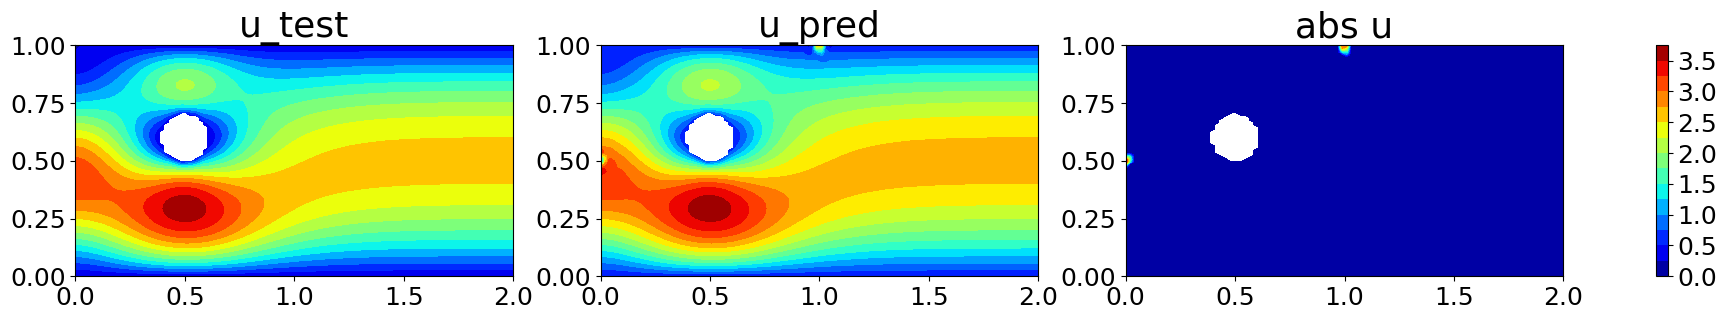

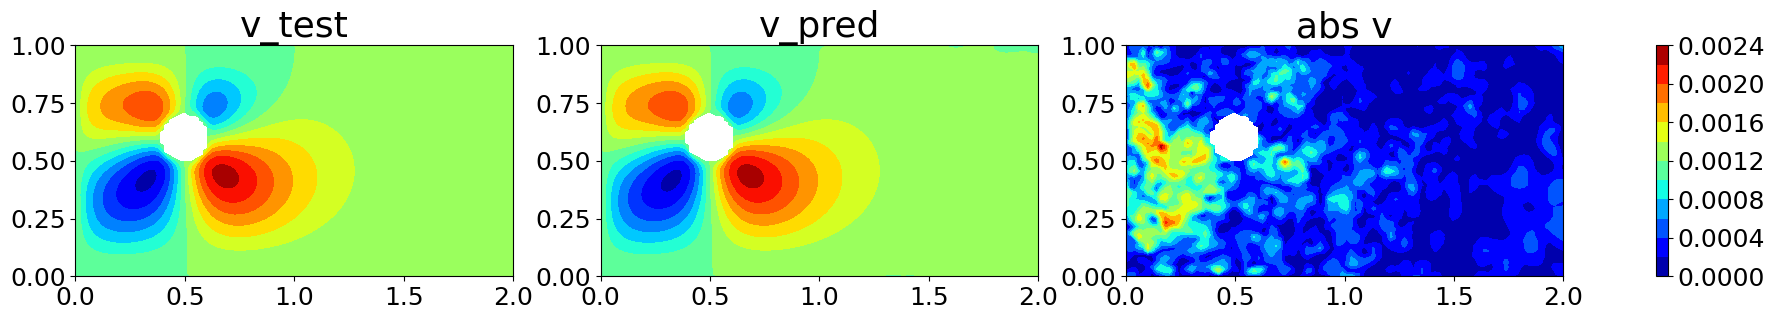

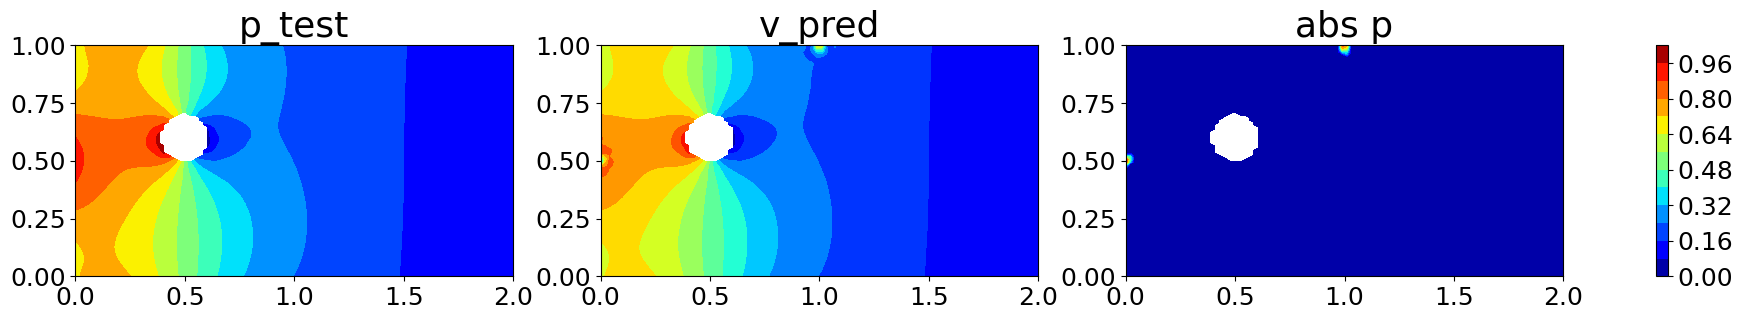

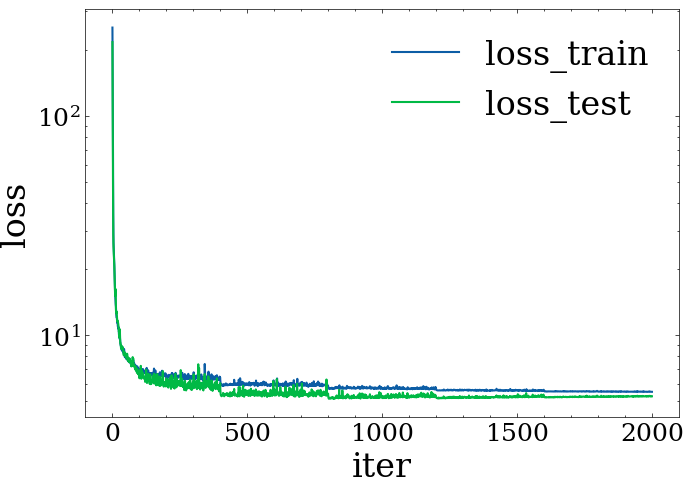

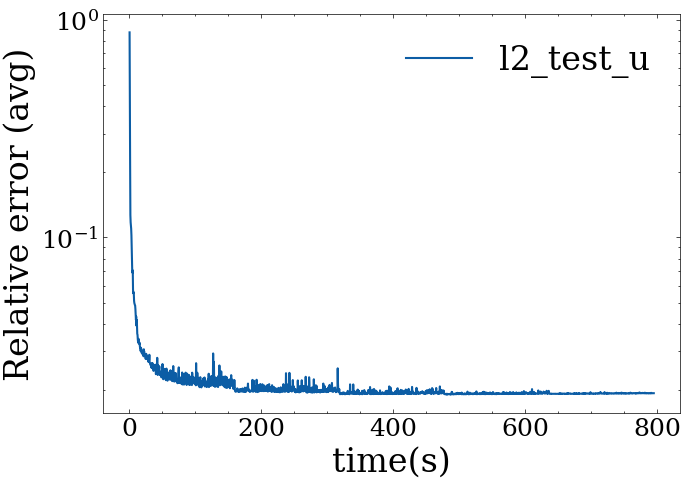

In [4]:
#####################################
# Load the trained model
#####################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', 
                                 name='model_multionet_final')

#########################################
with torch.no_grad():
    u_pred = model_trained['u'](x_test.to(device), a_test.to(device))
    v_pred = model_trained['v'](x_test.to(device), a_test.to(device))
    p_pred = model_trained['p'](x_test.to(device), a_test.to(device))
    #
    u_pred, v_pred, p_pred = u_pred.detach().cpu(), v_pred.detach().cpu(), p_pred.detach().cpu()
    u_test, v_test, p_test = uvp_test[...,0], uvp_test[...,1], uvp_test[...,2]
print('The test l2 error (u):', solver.getError(u_pred, u_test))
print('The test l2 error (v):', solver.getError(v_pred, v_test))
print('The test l2 error (p):', solver.getError(p_pred, p_test))
# # ########################################
from scipy.interpolate import griddata
#
xx, yy = np.meshgrid(np.linspace(0, 2.,100), np.linspace(0., 1., 100))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,3))
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_test[inx]), (xx, yy), method='cubic')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr0 = axs[0].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[0].set_title('u_test')
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_pred[inx]), (xx, yy), method='cubic')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr0 = axs[1].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[1].set_title('u_pred')
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(torch.abs(u_pred[inx]-u_test[inx])), (xx, yy), method='linear')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr0 = axs[2].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[2].set_title('abs u')
plt.colorbar(cntr0, ax=axs)
#
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,3))
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(v_test[inx]), (xx, yy), method='cubic')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr1 = axs[0].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[0].set_title('v_test')
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(v_pred[inx]), (xx, yy), method='cubic')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr1 = axs[1].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[1].set_title('v_pred')
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(torch.abs(v_pred[inx]-v_test[inx])), (xx, yy), method='linear')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr1 = axs[2].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[2].set_title('abs v')
plt.colorbar(cntr1, ax=axs)
#
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,3))
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(p_test[inx]), (xx, yy), method='cubic')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr1 = axs[0].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[0].set_title('p_test')
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(p_pred[inx]), (xx, yy), method='cubic')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr1 = axs[1].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[1].set_title('v_pred')
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(torch.abs(p_pred[inx]-p_test[inx])), (xx, yy), method='linear')
z_plot[(xx-0.5)**2+(yy-0.6)**2<0.1**2] = np.nan
cntr1 = axs[2].contourf(xx, yy, z_plot, levels=14, cmap='jet')
axs[2].set_title('abs p')
plt.colorbar(cntr1, ax=axs)
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_multionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']], [loss_saved['l2_test'][:,0], loss_saved['l2_test'][:,1], loss_saved['l2_test'][:,2]], 
                ['l2_test_u', 'l2_test_v', 'l2_test_p'])